In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import matplotlib.pyplot as plt

In [0]:
matplotlib.style.use('ggplot')

# Imports

In [0]:
import numpy as np
import pandas as pd
import requests

In [0]:
import os
import json
import time

from copy import deepcopy

In [0]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.getLogger("requests").setLevel(logging.ERROR) # silencing requests logging 

# Logging for this notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO) # set this to whatever you'd like

In [0]:
import locale
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.utf8;LC_NUMERIC=en_US.UTF-8;LC_TIME=en_US.UTF-8;LC_COLLATE=en_US.utf8;LC_MONETARY=en_US.UTF-8;LC_MESSAGES=en_US.utf8;LC_PAPER=en_US.UTF-8;LC_NAME=en_US.utf8;LC_ADDRESS=en_US.utf8;LC_TELEPHONE=en_US.utf8;LC_MEASUREMENT=en_US.UTF-8;LC_IDENTIFICATION=en_US.utf8'

# OpenFEC's new API feature: itemized data

Not long after we released our initial [how-to](http://sunlightfoundation.com/blog/2015/07/08/openfec-makes-campaign-finance-data-more-accessible-with-new-api-heres-how-to-get-started/) introducing the new [OpenFEC API](https://api.open.fec.gov/developers), the 18f team [announced that they were making even more available](https://18f.gsa.gov/2015/07/15/openfec-api-update/). This made our day, because they quickly ticked off two of the items on the wish list we had published: (1) endpoints for itemized data and (2) per-contributor and per-recipient aggregates. This followup post introduces some of the new additions and why they're so important. 

## What's (newly) available

The [official documentation](https://api.open.fec.gov/developers) for the API is the best source for getting to know what it has to offer, but here are some of the new things you can look forward to interacting with:

  1. **Filings** - All of the official records and reports that committees file with the FEC. This includes all of the (many) forms listed on the FEC's [forms page](http://www.fec.gov/info/forms.shtml).
  2. **Itemized Receipts** - Schedule A itemizes a committee's receipts from individuals and other organizations. You can now explore the entire list of contributions that make up the receipt totals listed in financial reports.
  3. **Itemized Disbursements** - Schedule B itemizes a committee's disbursements such as campaign expenditures, staff payments, or donations to other committees. This gives the line items that make up the disbursement totals listed in financial reports.
  4. **Receipt Aggregates** - Aggregates of Schedule A transaction amounts. Users can now obtain totals aggregated by:
    - Contributor (limited to contributors with FEC IDs)
    - Size
    - State
    - Zip Code
  
Needless to say, there are a lot of new questions we can ask with these kinds of resources. Let's dive in.

# What's new?

To review: the base URL is

In [0]:
BASE_URL = 'http://api.open.fec.gov/v1'

You'll also need a data.gov API key, which you can obtain [here](https://api.data.gov/signup/). I save my API keys in a plain text file in my home directory, so that they're always handy and so that I can use them without revealing them in notebooks like this one.

In [0]:
API_KEY = open(os.path.expanduser('~/.api-keys/data.gov'),'r').read().strip()

## New endpoints

The new additions to the OpenFEC API are the [schedules](https://api.open.fec.gov/developers#!/schedules) endpoints:

  - `/committee/{committee_id}/schedules`
  - `/schedules`
  
Under each of these branches are receipts endpoints (sourced from Schedule A):

  - `/schedules/schedule_a`
  - `/schedules/schedule_a/by_contributor`
  - `/schedules/schedule_a/by_size`
  - `/schedules/schedule_a/by_state`
  - `/schedules/schedule_a/by_zip`
  
...and the disbursements endpoints (sourced from Schedule B)

  - `/schedules/schedule_b`

## Documentation

We're going to cover a fair bit of ground in this introduction, but for more details on what's possible, check the [official OpenFEC API documentation](https://api.open.fec.gov/developers).

# API Wrappers

If you'd like, you can use the utility functions supplied in our [previous post](http://sunlightfoundation.com/blog/2015/07/08/openfec-makes-campaign-finance-data-more-accessible-with-new-api-heres-how-to-get-started/) to query the API.

There are also, however, a few open source projects on GitHub that are meant to make using the OpenFEC API a bit easier.

## PyOpenFEC

Jeremy Bowers started a python wrapper called [PyOpenFEC](https://github.com/jeremyjbowers/pyopenfec), which I have since made some contributions to. This demonstration will use PyOpenFEC. There are a couple of benefits to using this wrapper:

  - **Object Oriented Design** - the real power that an API wrapper can give is a good abstraction over the various endpoints that exist, and some straightforward helper functions that group related resources together
  - **Handles Rate Limits** - Itemized records will, of course, require a lot of API calls. The effective rate limit on the OpenFEC API is 100 calls per hour. This wrapper tries to avoid making the API angry by backing off when the user's rate limit is approaching.
  
PyOpenFEC is not available for installation via `pip` at the moment, but for now you can install it following the instructions in the repository's [README](https://github.com/boblannon/pyopenfec/blob/master/README.md) file.

Now you'll need to set an environment variable to store your API key where PyOpenFEC can find it. If you're writing a script and running it from the command line, you can export the env variable just before you call the script:

    $>export OPENFEC_API_KEY=your_api_key && python myscript.py
    
In the IPython notebook, you'll run the `%env` magic.

In [0]:
%env OPENFEC_API_KEY=GLIbeNxQRAO4Z5S7buBeMpxiX7AopoSbi5hqSZBI

env: OPENFEC_API_KEY=GLIbeNxQRAO4Z5S7buBeMpxiX7AopoSbi5hqSZBI


In [0]:
#%env OPENFEC_API_KEY=your_api_key

Then all you need to do is:

In [0]:
import pyopenfec as api

## Other wrappers

Underscoring the excitement in the OpenGov community, two other wrappers have also appeared. Check them out, and contribute!
  
  * [mheadd/openfec](https://github.com/mheadd/openfec) Mark Headd's node.js wrapper
  * [tmc/openfec](https://github.com/tmc/openfec) - Travis Cline's Go wrapper

# Itemized Records

Back on July 31st (a key FEC filing deadline), a [bunch of campaign finance nerds](https://twitter.com/asmith83/lists/fun-with-fec-filings) (including myself) watched more than 780 filings roll in. A few of us were [live-tweeting](https://twitter.com/search?q=from%3ARobertMaguire_%2C%20OR%20from%3Arebeccaballhaus%2C%20OR%20from%3Amjbeckel%2C%20OR%20from%3Alevinecarrie%2C%20OR%20from%3AJDSalant%2C%20OR%20from%3Ateddyschleifer%2C%20OR%20from%3Anickconfessore%2C%20OR%20from%3ABobLannon%2C%20OR%20from%3Adavelevinthal%2C%20OR%20from%3AHotlineScott%2C%20OR%20from%3Agreggiroux%2C%20OR%20from%3Akenvogel%2C%20OR%20from%3AEveryVoice%2C%20OR%20from%3Awjtuck%2C%20OR%20from%3Aapalmerdc%2C%20OR%20from%3AAdamWollner%2C%20OR%20from%3ARobertFaturechi%2C%20OR%20from%3Abykowicz%2C%20OR%20from%3Afschouten%2C%20OR%20from%3AOpenSecretsDC%20since%3A2015-07-31%20until%3A2015-08-01&src=typd&lang=en). This is fun for our kind.


Most of the initial reactions that went out were big numbers being reported by PACs. That kind of summary data was previously available when we posted the first OpenFEC API how-to. Some of the more interesting stories, though, took some digging. Itemized receipts and disbursements can sometimes tell us things that the top line numbers can't. 

Take, for instance, this infographic, which used itemized contributions to show the day-by-day growth of Right to Rise USA, which is a pro-Bush Super PAC:

    <blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">Awesome graphic by <a href="https://twitter.com/stuartathompson">@stuartathompson</a>: Bush super PAC&#39;s race to $103 million: <a href="http://t.co/58XaTfBRsS">http://t.co/58XaTfBRsS</a> <a href="http://t.co/umh53UtC5w">pic.twitter.com/umh53UtC5w</a></p>&mdash; Rebecca Ballhaus (@rebeccaballhaus) <a href="https://twitter.com/rebeccaballhaus/status/627210125942521856">July 31, 2015</a></blockquote>

Pretty cool, right? The itemized records give us a closer look at the history of contributions to this Super PAC, and we can start to ask why fundraising accelerated more during some periods than others.

Itemized records also allow us to dig deeper into the make-up of Super PAC donor lists. As [Idrees Kahloon pointed out](http://sunlightfoundation.com/blog/2015/08/03/outside-groups-influence-on-2016-election-grows-super-pac-filings-show/), for most of the presidential Super PACs, those big dollar aggregates were largely contributed by a small pool of big money donors. For my part, I focused on this element of the incoming filings: 

Okay, enough retweeting. Let's see how you can use the OpenFEC API to dig into these itemized contributions and disbursements

## Itemized Receipts (Schedule A)

To get used to using PyOpenFEC, let's search for one of the presidential Super PACs above. The classes in this wrapper have class methods for accessing results (eg, `count`, `fetch`), but also produce instances of that class as a result. For example, the `Committee` class has a `search` method that can be called which will return objects that are instances of the `Committee` class:

In [0]:
promise_keepers = [c for c in api.Committee.search('Keep the Promise')]

In [0]:
promise_keepers

In [0]:
for i,p in enumerate(promise_keepers):
    print('[{i}] {id}: {n} ({t})'.format(i=i, id=p.committee_id, n=p.name, 
                                         t=p.committee_type) )

[0] C99002503: COMMITTEE FOR THE EARLY RETIREMENT OF SENATORS WHO DON'T KEEP THEIR CAMPAIGN PROMISES (U)
[1] C00575373: KEEP THE PROMISE I (O)
[2] C00575431: KEEP THE PROMISE II (O)
[3] C00575423: KEEP THE PROMISE III (O)
[4] C00575415: KEEP THE PROMISE PAC (O)


Okay, that first one is hilarious. But let's focus on items 1-4 in that array, which are the pro-Cruz Super PACs.

In [0]:
ktp_i = promise_keepers[1]
ktp_ii = promise_keepers[2]
ktp_iii = promise_keepers[3]
ktp = promise_keepers[4]

The `Committee` objects have helper functions for grabbing associated filings, reports, histories, etc.

In [0]:
ktp_i.totals[2016].receipts

11007100

Let's see how much each of these Super PACs brought in:

In [0]:
for c in [ktp, ktp_i, ktp_ii, ktp_iii]:
    total_receipts = locale.currency(c.totals[2016].receipts, grouping=True)
    print("{c}: {r}".format(c=c.name, r=total_receipts))

KEEP THE PROMISE PAC: $1,826,500.00
KEEP THE PROMISE I: $11,007,100.00
KEEP THE PROMISE II: $10,000,000.00
KEEP THE PROMISE III: $15,000,000.00


That's a bunch of money, but let's dig deeper.

There was a lot of speculation, but it wasn't clear to those watching the race why Cruz set up so many different Super PACs. Let's see what the itemized receipts can tell us:

In [0]:
ktp_i_receipts = [r for r in ktp_i.all_receipts()]

In [0]:
ktp_i_receipts[0].to_dict()

{'amendment_indicator': None,
 'back_reference_schedule_name': None,
 'back_reference_transaction_id': None,
 'committee': {u'city': u'PORT JEFFERSON STA',
  u'committee_id': u'C00575373',
  u'committee_type': u'O',
  u'committee_type_full': u'Super PAC (Independent Expenditure-Only)',
  u'cycle': 2016,
  u'cycles': [2016],
  u'designation': u'U',
  u'designation_full': u'Unauthorized',
  u'expire_date': None,
  u'name': u'KEEP THE PROMISE I',
  u'organization_type': None,
  u'organization_type_full': None,
  u'party': None,
  u'party_full': None,
  u'state': u'NY',
  u'state_full': u'New York   ',
  u'street_1': u'2 ROOSEVELT AVENUE',
  u'street_2': None,
  u'treasurer_name': u'JACQUELYN JAMES',
  u'zip': u'11776'},
 'committee_id': u'C00575373',
 'contributor': None,
 'contributor_aggregate_ytd': 1490.63,
 'contributor_city': u'SAN ANTONIO',
 'contributor_employer': None,
 'contributor_first_name': None,
 'contributor_id': None,
 'contributor_last_name': None,
 'contributor_middle_na

Lots of information in there. Let's do some sorting and figure out who the big dollar donors are.

In [0]:
ktp_i_receipts_df = pd.DataFrame([r.to_dict() for r in ktp_i_receipts])
ktp_i_receipts_df.sort('contributor_receipt_amount', ascending=False)[
    ['contributor_name', 'contributor_receipt_amount']
    ]

,contributor_name,contributor_receipt_amount
4,"MERCER, ROBERT",11000000.00
3,"HANLEY, WILLIAM LEE JR.",5000.00
0,CHASE BANK,863.00
2,CHASE BANK,627.63
1,CHASE BANK,405.37


Ah ha!  It looks like the money associated with Keep The Promise I was almost entirely from one donor. Maybe this holds true for all of the others.

In [0]:
cruz_super_pac_receipts = []

for c in [ktp_i, ktp_ii, ktp_iii]:
    for r in c.all_receipts():
        cruz_super_pac_receipts.append(r.to_dict())

In [0]:
cruz_super_pac_receipts_df = pd.DataFrame(cruz_super_pac_receipts)

(quick fix, here, to make it easier to display the committees' names)

In [0]:
cruz_super_pac_receipts_df['committee_name'] = cruz_super_pac_receipts_df['committee'].map(lambda x: x['name'])

For each committee, we'll take the top 10 donors by contribution amount (using the pandas `head()` function).

In [0]:
cruz_super_pac_top_donors = cruz_super_pac_receipts_df.sort(
                                                          'contributor_receipt_amount'
                                                      ).groupby(
                                                          'committee_id'
                                                      ).head()

cruz_super_pac_top_donors.sort(
    ['committee_name', 'contributor_receipt_amount'], ascending=False
)[['committee_name', 'contributor_name', 'contributor_receipt_amount']]

,committee_name,contributor_name,contributor_receipt_amount
7,KEEP THE PROMISE III,"WILKS, FARRIS",5000000.00
8,KEEP THE PROMISE III,"WILKS, JO ANN",5000000.00
6,KEEP THE PROMISE III,"WILKS, DANIEL",2500000.00
9,KEEP THE PROMISE III,"WILKS, STACI",2500000.00
5,KEEP THE PROMISE II,"NEUGEBAUER, TOBY",10000000.00
4,KEEP THE PROMISE I,"MERCER, ROBERT",11000000.00
3,KEEP THE PROMISE I,"HANLEY, WILLIAM LEE JR.",5000.00
0,KEEP THE PROMISE I,CHASE BANK,863.00
2,KEEP THE PROMISE I,CHASE BANK,627.63
1,KEEP THE PROMISE I,CHASE BANK,405.37


As [many have reported](http://www.politico.com/story/2015/07/ted-cruz-super-pacs-rake-in-38-million-120889.html), it seems like these Super PACs were apparently tailor-made to collect money from specific individual large-money donors. That's pretty new behavior, but plain to see when we take a look at the itemized receipts.

## Itemized Disbursements (Schedule B)

Digging through the money spent by committees can be just as fun:

Searching through Keep The Promise I's disbursements, for instance, we can find something pretty surprising:

In [0]:
ktp_i_disbursements = [r for r in ktp_i.all_disbursements()]

for d in ktp_i_disbursements:
    amt = locale.currency(d.disbursement_amount, grouping=True)
    print("{r}: {a}".format(a=amt, r=d.recipient_name))

CARLY FOR AMERICA: $500,000.00
THE POLLING COMPANY: $20,000.00
BRACEWELL & GIULIANI LLP: $16,169.00


It looks as if their top recipient is Carly for America, which is as Super PAC started by Carly Fiorina. That's pretty strange, and, in fact, it [made news](http://www.cnn.com/2015/07/31/politics/carly-fiorina-super-pac/) that week, with CNN reporting that Keep The Promise I's top donor, Robert Mercer, had given money directly to Fiorina's campaign as well:

<blockquote>
Though Mercer is heavily investing in Cruz's campaign for president, the financier seems to have also taken a liking to Fiorina -- he cut a $2,700 check to Fiorina's campaign in May. The treasurer of Keep the Promise I, Jacquelyn James-Varga, did not respond to a request for comment. A spokesperson for Carly for America also declined to comment on the sizeable contribution from Keep the Promise I.
</blockquote>

# HERE BE DRAGONS!!!

_What follows is a preview of next week's post about aggregate endpoints. It's being delayed because of a couple of issues ([1](https://github.com/18F/openFEC/issues/1137)) ([2](https://github.com/18F/openFEC/issues/1138)) that apparently need to be resolved on the API._

As was mentioned above, the OpenFEC API has also added aggregate views of the itemized receipts data. This makes it possible to break out the total receipts numbers by different attributes. Let's take a look at what we can learn from these endpoints.



For each of these aggregates, we'll compare the top four campaign committees (in terms of funds raised).  We'll start by fetching the statutory candidates for president from the two major parties:

In [0]:
major_party_candidates = {
    'party': ['DEM', 'REP'],        # for now, limit to D's and R's
    'candidate_status': 'C',        # statutory candidates
    'office': 'P'                   # running for president
}

presidential_candidates = api.Candidate.fetch(**major_party_candidates)

Now we'll look at their campaign committees:

In [0]:
prez_campaign_committees = []

for cand in presidential_candidates:
    if 2016 in cand.committees:
        for comm in cand.committees[2016]:
            if comm.designation == 'P' and comm.committee_type == 'P':
                prez_campaign_committees.append(comm)

And now we'll get the 2016 totals for each of those campaign committees:

In [0]:
prez_campaign_totals = []

for comm in prez_campaign_committees:
    if 2016 in comm.totals:
        comm_totals = comm.totals[2016].to_dict()
        comm_totals['committee_name'] = comm.name
        prez_campaign_totals.append(comm_totals)

prez_campaign_totals_df = pd.DataFrame(prez_campaign_totals)

Sorting by receipts, we can see who the top four are:

In [0]:
top_4_df = prez_campaign_totals_df.sort('receipts', ascending=False).head(4)[['committee_name', 'committee_id', 'receipts']]
top_4_df

,committee_name,committee_id,receipts
7,HILLARY FOR AMERICA,C00575795,47549900
27,BERNIE 2016,C00577130,15247400
8,CRUZ FOR PRESIDENT,C00574624,14349180
2,"JEB 2016, INC.",C00579458,11429900


This will be our set of committees for the comparisons below.

In [0]:
top_4 = [c for c in prez_campaign_committees if c.committee_id in list(top_4_df['committee_id'])]

## Receipts by Size

The `/schedules/schedule_a/by_size` endpoint gives us the count and total amount of contributions in each of five buckets:

  - `$200 and under`
  - `$200.01 - $499.99`
  - `$500 - $999.99`
  - `$1000 - $1999.99`
  - `$2000 +`

Actually, that first bucket doesn't come from Schedule A. Contributions of less than $$200 don't need to be itemized by commitees. The "$200 and under" bucket is sourced from the summary section's total of unitemized contributions.

Let's see how this plays out if we look at a few of the presidential candidates.

In [0]:
top_4_by_size = []

for comm in top_4:
    for r in comm.total_receipts_by_size():
        agg = r.to_dict()
        agg['committee_name'] = comm.name
        top_4_by_size.append(agg)

In [0]:
top_4_by_size_df = pd.DataFrame(top_4_by_size)

In [0]:
top_4_by_size_df.pivot_table(index='committee_name', columns='size', values='total')

size,0,200,500,1000,2000
committee_name,,,,,
BERNIE 2016,10465900,NaN,NaN,NaN,NaN
CRUZ FOR PRESIDENT,1832878,175956.31,194254.1,364502,1835613
HILLARY FOR AMERICA,8098550,NaN,NaN,NaN,NaN
"JEB 2016, INC.",368023,NaN,NaN,NaN,NaN


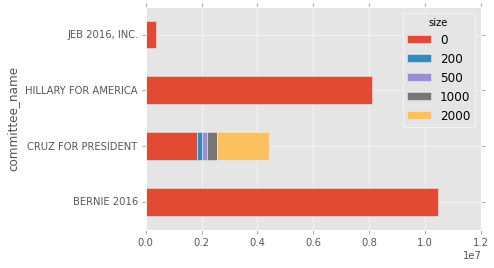

In [0]:
top_4_by_size_df.pivot_table(index='committee_name', columns='size', values='total').plot(kind='barh', stacked=True)

In [0]:
top_4_by_size_df.groupby('committee_name')

,count,cycle,size,total
committee_name,,,,
BERNIE 2016,NaN,2016,0,10465900.00
CRUZ FOR PRESIDENT,1938,10080,3700,4403203.41
HILLARY FOR AMERICA,NaN,2016,0,8098550.00
"JEB 2016, INC.",NaN,2016,0,368023.00
